# 1. 图片分类vs目标检测

<img src="./pic/图片分类vs目标检测1.PNG" width=400 height=400>

## 边缘框

- 一个边缘框可以通过4个数字定义
    - （左上X，左上Y，右上X，右下Y）
    - （左上X，左上Y，宽，高）
<img src="./pic/边缘框.PNG" width=200 height=200>

## 目标检测数据集

- 每一行表示一个物体
    - 图片文件名，物体类别，边缘框（每行有6个值，边缘框4个值）
    - 当一个图片文件名里有多个物体时，图片文件名可能多次出现
        - 假如一个图片里有5个物体，那么图片文件名会出现5次
- COCO（cocodataset.org）
    - 80类物体，330k图片，1.5M物体
<img src="./pic/目标检测数据集.PNG" width=400 height=400>

## 总结
- 物体检测识别图片里多个物体的类别和位置
- 位置通常用边缘框表示

# 2. 边缘框代码

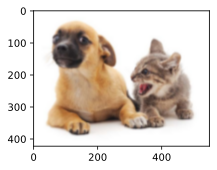

In [8]:
import torch
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.plt.imread('./pic/catdog.png')
d2l.plt.imshow(img);

## 2.1 定义在这两种表示法之间进行转换的函数

- box_corner_to_center从两角表示法转换为中心宽度表示法
- box_center_to_corner反之亦然
- 输入参数boxes可以是长度为4的张量，也可以是形状为（，4）的二维张量，其中是边界框的数量

In [9]:
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

## 2.2 定义图像中狗和猫的边界框

In [10]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]


# 通过转换两次来验证边界框转换函数的正确性
boxes = torch.tensor((dog_bbox, cat_bbox))

# 一个box，从corner转center，再转corner，应该等于自己
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

## 2.3 将边界框在图中画出

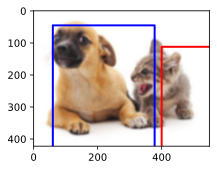

In [11]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), # 左上X，左上Y
                             width=bbox[2]-bbox[0], # 宽
                             height=bbox[3]-bbox[1], # 高
                             fill=False, edgecolor=color, linewidth=2)


fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# 3. 目标检测数据集

In [12]:
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l


d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')

## 3.1 读取香蕉检测数据集

In [13]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    # 每一行是一个物体：（图片文件名，物体类别，边缘框）
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' 
                                                             if is_train else 'bananas_val', 'images', f'{img_name}'))) # torchvi把图片读到内存里
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256     # 把标号1-5（边缘框）除以256。虽然存储是按像素，但是读取位置时除以256，映射到0到1之间的实数

# 这样图片的大小改变时,香蕉的坐标也会相应改变,但是香蕉的相对位置不会改变.

## 3.2 创建一个自定义`Dataset`实例

In [15]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):    # 单分类问题，没有label标号
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

## 3.3 为训练集和测试集返回两个数据加载器实例
- 对于测试集，无须按随机顺序读取它

In [17]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

## 3.4读取一个小批量，并打印其中的图像和标签的形状
- `batch[0]`是图片
    - shape: ([32, 3, 256, 256])
    - ([batch size, RGB channel, height, witdh])
- `batch[1]`是标签
    - shape: ([32, 1, 5])
    - (32:批量大小，1:每张图片上最多有多少种物体，5:（标号label，4个坐标）)

In [19]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

In [27]:
batch[1][0]    # 第一张有边缘框的图片

tensor([[0.0000, 0.6172, 0.7227, 0.8242, 0.9219]])

## 演示
- 10幅带有真实边界框的图像
    - 可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。 
    - 这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。

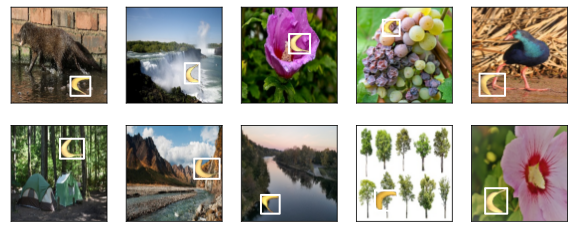

In [31]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255    # permute将通道移到最后（batch size, height, width, channel）
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):    # 拿出10张图片
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])    # 标号1:5显示边缘框，标号0为物体种类

# 通常边缘框的数值是0到1之间。一般边缘框保存之后，除以了高宽